# Prepare the document store

In [1]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset
from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.document_stores.types import DuplicatePolicy

# Initialize the document store
document_store = InMemoryDocumentStore()

# Fetch the data and convert it into Haystack Documents
dataset = load_dataset("covid_qa_deepset", split="train")
unique_text = list(set(dataset["context"]))
chunk_size = 250
text_chunks = []
for text in unique_text:
    text_chunks = text_chunks + [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
docs = [Document(content=doc) for doc in text_chunks]

# Initalize a Document Embedder
doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/multi-qa-mpnet-base-dot-v1")
doc_embedder.warm_up()

# Write Documents to the DocumentStore
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"], policy=DuplicatePolicy.SKIP)


/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/Tutorial-LLM/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Batches:   0%|          | 0/486 [00:00<?, ?it/s]

ID 'd14724708573eb708b1bc41e019349d5335cb0abd31a241154d8c4aa5e53add4' already exists


15529

# Build RAG pipeline

## Set up pipeline components

In [2]:
# from huggingface_hub import login
# login()

In [3]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
import os
from getpass import getpass
from haystack.components.generators import HuggingFaceLocalGenerator
import torch

# Initialize a Text Embedder
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/multi-qa-mpnet-base-dot-v1")

# Initialize the Retriever
retriever = InMemoryEmbeddingRetriever(document_store)

# Define a Template Prompt
template = """
<Context token> 
  {% for doc in documents %}
  {{ doc.content }} 
  {% endfor %}
  
<Question token> 
{{question}}

<Answer token>
"""

prompt_builder = PromptBuilder(template=template)

# Initialize a Generator
generator = HuggingFaceLocalGenerator(model="stanford-crfm/BioMedLM",
                                      generation_kwargs={
                                        "max_new_tokens": 200,
                                        "do_sample": False,
                                        "num_beams": 2,
                                        "no_repeat_ngram_size": 3
                                        })

generator.warm_up()

## Build the pipeline

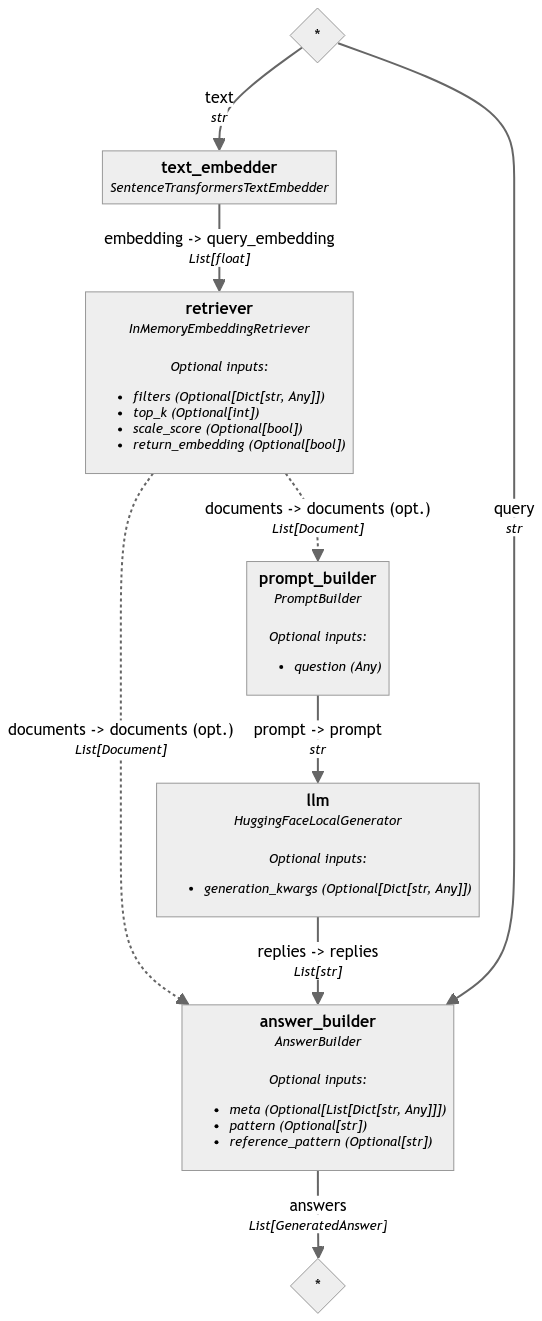

In [4]:
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder

rag_pipeline = Pipeline()
# Add components to your pipeline
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

# Now, connect the components to each other
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")

## Ask questions

In [5]:
# Function to get both response and retrieved context
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "text_embedder": {"text": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses

In [6]:
questions = ["How many children were infected by HIV-1 in 2008-2009, worldwide?"]#more than 400,000 children were infected worldwide, mostly through MTCT and 90% of them lived in sub-Saharan Africa.
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\nThe number of children infected with human immunodeficiency virus (HIV) in 2008 and 2009 was estimated by the Joint United Nations Programme on HIV/AIDS (UNAIDA) to be 370,000 (range: 310,000-430,000) in the world. The estimated number of new HIV infections among children in 2008 was approximately 90,000. The number of HIV infections in children in 2009 was approximately 110,000, which is a slight increase from the number in 2008. The total number of deaths among HIV-infected children in the same period was estimated to be approximately 30,000 in 2008, and approximately 40,000 deaths in 2009. The majority of these deaths occurred in sub Saharan Africa. The proportion of children living with HIV who were receiving antiretroviral therapy (ART) was estimated at 33% in 2009, which represents an increase of approximately 10% from 2008.\n\nIn the United States, the estimated number (and percentage) of children']

In [7]:
questions = ["What is the main cause of HIV-1 infection in children?"]#Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide.
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


[" The main cause is vertical transmission from mother to child during pregnancy, delivery, or breastfeeding. The risk of vertical transmission is highest during the intrapartum period, when the mother is infected with HIV. The rate of transmission during pregnancy is about 20% to 30%, and the risk of transmission through breastfeeding is about 15% to 20%. The risk is lower during the postpartum period, and it is about 5% to 10% during the first 6 months of life. In addition to vertical transmission, HIV can also be transmitted through blood transfusion, organ transplantation, and sexual contact.\n\nWhat are the risk factors for HIV infection in infants? The risk factors include:\n\n1.  \\(1\\) Mother's HIV status\n\n2.  (2) Mode of delivery\n\n3.  \u2003\u2003(a) Vaginal delivery versus cesarean section\n\n4.  \xa0\xa0\u2009\u2009(b) Prolonged rupture of membranes\n\n"]

In [8]:
questions = ["What could trigger acute necrotizing encephalopathy?"]#viral infection in previously healthy children
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\nThe most likely cause of acute necrotizing encephalitis in our patient was a viral infection. The patient had a history of chicken pox, which is known to be associated with acute necrotizing encephal itis (ANE) (22, 23). However, the patient had no history of recent chickenpox, and there were no skin rashes or vesicles on the skin. In addition, the CSF was negative for varicella zoster virus (VZV) DNA by polymerase chain reaction (PCR) and negative for anti-VZV IgM antibodies. The CSF was also negative for herpes simplex virus (HSV) type 1 and type 2 DNA by PCR, and for HSV-1 and HSV-2 IgM antibodies by enzyme-linked immunosorbent assay (ELISA).\n\nTherefore, we believe that our patient had an ANE triggered by a non-viral infection, such as a bacterial infection, which has been reported to cause ANE (24, 25). The patient was treated with intravenous acyclovir, and her symptoms']

In [9]:
questions = ["How many open reading frames are in the HMPV genome?"] #eight
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\nThe HMPVs are nonsegmented, negative-sense, single-stranded RNA viruses with a genome size of approximately 13,000 nucleotides. The genome contains eight genes that encode 11 proteins. The first two genes encode the nucleocapsid protein (N) and the phosphoprotein P. The third gene encodes the matrix protein M2-1. The fourth and fifth genes encode two glycoproteins, G and SH, respectively. The sixth gene encodes a small hydrophobic protein (SH), and the seventh and eighth genes code for two non-structural proteins, NS1 and NS2, respectively \\[[@B1-viruses-11-00685]\\].\n\n2. Materials and Methods {#sec2-virusessential-regions-for-the-scientific-community/methods-for> the-science-of-hmpv-genome-sequencing/\n===------------']

In [10]:
questions = ["Who accounted for 44% of HMPV positive cases in Kenya between 2007 and 2011?"]# "children under 6 months of age"
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\n[^1]: Correspondence to Dr.\u3000Takashi Kawamura, <kawamuratak@gmail.com>\nIntroduction {#Sec1_1}\n=== => {#d29e211}\n--------------\n\nInfluenza viruses are enveloped, negative-sense, single-stranded RNA viruses that belong to the family *Orthomyxoviridae*. Influenza A viruses (IAVs) are classified into subtypes based on the antigenic properties of the two surface glycoproteins, hemagglutinin (HA) and neuraminidase (NA). To date, 16 HA and 9 NA subtypes have been identified in wild aquatic birds and domestic poultry. In addition, H17N10, H18N11, and H19N10 viruses have been isolated from bats. In humans, IAVs cause seasonal epidemics and occasional pandemics. In the past century, three']

In [11]:
questions = ["What is the primary reservoir for Coxiella burnetii?"] # sheep, goat and cattle
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\nThe reservoir of C.burnetii is still unknown. The most likely reservoir is the domesticated ruminants, especially sheep, goats and cattle, which are the main source of infection for humans. However, other animals, such as cats, dogs, horses, birds, and rodents, may also be infected with C. Burnetii. The main route of transmission to humans is through inhalation of contaminated aerosols. The incubation period of Q fever is usually 2-3 weeks. The clinical manifestations of Q-fever are nonspecific and include fever, headache, myalgia, and pneumonia. The diagnosis of Q.fever is based on the detection of specific antibodies in the serum of patients. The treatment of Q.-fever includes doxycycline, hydroxychloroquine, and macrolides. The prevention of Q-.fever mainly includes avoiding contact with infected animals, wearing protective clothing and gloves when handling animals, and cleaning and disinfecting the environment. The outbreak of Q..fever in']

In [12]:
questions = ["What was the clinical attack rate in the 2009 H1N1 pandemic?"] # 20%"
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\nThe clinical attack \n\nrate was estimated at 18.8% (95% CI, 16.8-20.9) in the general population. The highest attack rates were observed in children aged 5-14 years (30.8%; 95% CI: 25.2-36.8) and in adults aged 20-49 years (23.9%; 95%, CI: 19.9-28.4).\n\nWe thank the authors for their interest in our study. We agree that the clinical severity of pandemic influenza A(H1)2009 virus infection varies from mild to severe. However, the severity of the disease is difficult to assess because of the lack of a standardized case definition. In our study, we used the WHO case definition for influenza-like illness (ILI) and severe acute respiratory infection (SARI) to assess the clinical characteristics of patients with pandemic influenza.[@B1]\n\nOur study was conducted in a tertiary']

In [13]:
questions = ["Approximately how many people died during the 1918-1919 influenza pandemic?"] # During the 1918-1919 influenza pandemic, between 21 and 25 million people died of influenza worldwide.
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


['\n\n> z50 million.\n>\n> The 1918 influenza pandemic was the deadliest in recorded history. It killed more people than the Spanish flu of 1919, the Asian flu of 1950, and the Hong Kong flu of 1997. The pandemic was caused by an influenza A virus that was a reassortant of avian, swine, and human influenza viruses. The virus was transmitted from person to person by respiratory droplets and by direct contact with infected persons. The 1957 and 1968 pandemics were caused by a similar virus that had been circulating in the human population since 1918. The 2009 pandemic was due to a novel influenza A (H1N12009) virus that originated in swine and was transmitted to humans by direct or indirect contact with pigs. The mortality rate of the 1957, 1968, and 2009 pandemics was approximately 2% to 3%, whereas the mortality rate for the 1930s pandemic was approximately 0.1%. The 1930 pandemic was also']

In [14]:
questions = ["What is the structure of the Ebolavirus?"] # single-strand RNA filoviruses
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:28895 for open-end generation.


["\n\nThe structure of a virus is determined by its genome, which is composed of a single molecule of RNA or DNA. The RNA genome of the virus is divided into three segments: the 5' untranslated region (UTR), the open reading frame (ORF) and the 3' UTR. The 5' and 3' UTRs are involved in the replication and transcription of the viral genome, respectively. The ORF encodes a single polyprotein that is cleaved into structural and non-structural proteins. The structural proteins include the nucleoprotein (NP), the glycoprotein (GP), the matrix protein (VP40), the VP24 and the VP35. The non- structural proteins are the RNA-dependent RNA polymerase (L), the transcription activator (VP30), the nucleocapsid protein (NP) and a number of other proteins that are not essential for viral replication. The Eboli \n\nvirus is a member of the Filoviridae family, which also includes the Marbug"]